In [1]:
#extract dataset


import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import random #on veut mélanger les images

targets = []
features = [] #pixels de l'image

files = glob.glob('resultatCartes/*.jpeg') #dans le même dossier que le programme
#* permet de prendre tous les fichiers qui finissent par jpg
random.shuffle(files)

for file in files:
    features.append(np.array(Image.open(file).resize((75, 75))))#permet de dominuer le temps de calcule en réduisant les images
    target = [1, 0] if "rouge" in file else [0, 1]# on modifie target en fonction de si rouge ou noir
    targets.append(target)



features = np.array(features)
targets = np.array(targets)

print("features shape", features.shape)
print("Targets shape", targets.shape)

features shape (176, 75, 75, 3)
Targets shape (176, 2)


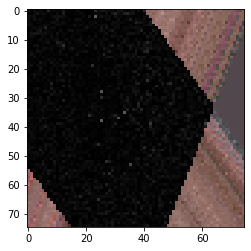

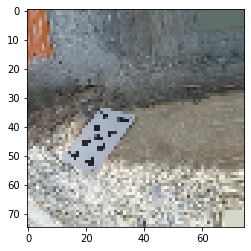

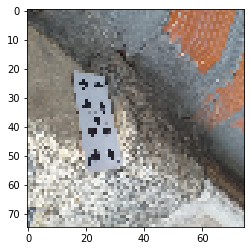

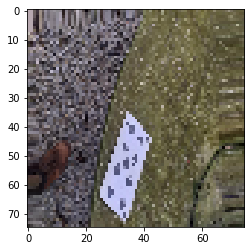

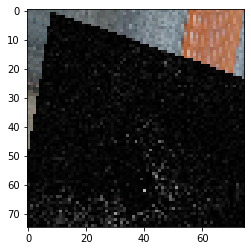

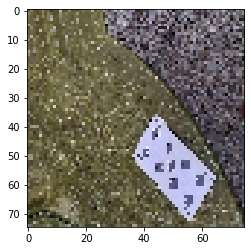

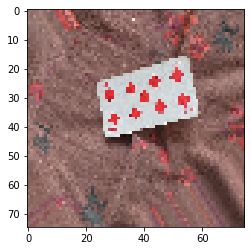

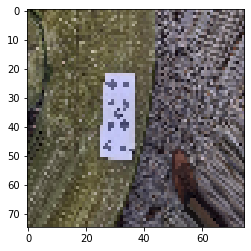

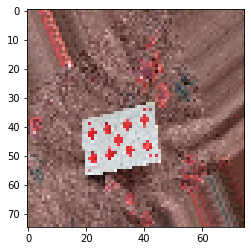

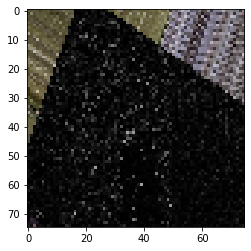

In [2]:
#show image

from random import randint

for a in [randint(0, len(features)) for _ in range(10)]:#on génère des nombre entre 0 et la longueur de la target cad toutes les images possibles
    plt.imshow(features[a])
    plt.show()
    

In [3]:
#jeu d'entraînement et de validation

from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(features, targets, test_size=0.05, random_state=42)

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_valid.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_valid.shape)

X_train.shape (167, 75, 75, 3)
X_valid.shape (9, 75, 75, 3)
y_train.shape (167, 2)
y_valid.shape (9, 2)


In [4]:
## création du modèle

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from tensorflow import keras


# Placeholder #entrées de notre modèle
x = tf.placeholder(tf.float32, (None, 75, 75, 3), name="x")#pixels, le none correspond au fait qu'on lui met autant d'images 
#qu'on veut. Et (75 75 3) => images de 75*75 (cf resize) * 3 (image RGB).
y = tf.placeholder(tf.float32, (None, 2), name="y")#pour les targets, autant qu'on veut à 2 dimensions
dropout = tf.placeholder(tf.float32, (None), name="dropout") #permet d(enlever des neurones qui ne servent plus à rien)


def create_conv(prev, filter_size, nb):#prev est ce qui vient avant, cad l'image
#nb= nombre de filtres qu'on veut
    # First convolution
    conv_W = tf.Variable(tf.truncated_normal(shape=(filter_size, filter_size, int(prev.get_shape()[-1]), nb)))
    #pour chaque image précédente, on prendra 32 filtres pour les 3 channels (R, G et B) de taille 8*8
    conv_b = tf.Variable(tf.zeros(nb)) #pour chacun de nos filtres, on a les bytes (?)
    conv   = tf.nn.conv2d(prev, conv_W, strides=[1, 1, 1, 1], padding='SAME') + conv_b
    #prend en entrée input, filtre, padding
    #l'image entrée est x, elle a besoin des poids associés (filtre), le strides est de combien de pixels le filtre se déplace
    #pour un stride de 2, je me déplace de 2 pixels à chaque fois, ce qui est important dans le strides du dessus
    #c'est les 1 du milieu (les 2)
    #padding: same => l'image qui sort est toujours de la même taille originale. Quand le filtre arrive aux bords de l'image
    #il considère qu'il y a des 0 en dehors de l'image, et ressort une image de la même taille
    #on vient de créer une nouvelle image de 75*75*32
    #si on met padding=valid, on a une image plus petite
    # Activation: relu
    conv = tf.nn.relu(conv)
    # Pooling
    conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')#on se déplace de 2*2, donc on divise la 
    #taille par 2
    return conv

#les tailles de filtres ici sont assez standards. Idéalement il faudrait aller chercher
#les tailles de filtres appropriées.
conv = create_conv(x, 8, 32)#filtrez de 8*8, et on en veut 32
conv = create_conv(conv, 5, 64)
conv = create_conv(conv, 5, 128)
conv = create_conv(conv, 5, 256)
conv = create_conv(conv, 5, 215)

#print(conv) #on se retrouve avec des filtres 3*3*256, donc de profondeur 256
#on aplatit tout

@tf.function
def Flatten(x):
  y = Flatten()(x)
  return y

#arrive jusque là
#flat = nest.flatten_dict_items(tf.dict(conv))#2304 valeurs
flat=tf.keras.layers.Flatten()(conv)
#on convertit en dictionnaire pour utiliser le flat
#print(flat, flat.get_shape()[1])
a=input()#arrive jusque là ?
print(flat)                              

# First fully connected layer
fc1_W = tf.Variable(tf.truncated_normal(shape=(int(flat.get_shape()[1]), 512))) #flat.getshape=> nombre de neurones de la couche précédente
fc1_b = tf.Variable(tf.zeros(512))#on crée notre bayes
fc1   = tf.matmul(flat, fc1_W) + fc1_b#opération matricielle pour obtenir nos poids

# Activation.
fc1    = tf.nn.relu(fc1)

#fc1 = tf.nn.dropout(fc1, keep_prob=dropout)

# Last layer: Prediction
fc3_W  = tf.Variable(tf.truncated_normal(shape=(512, 2)))#neurones qui prédisent nos sorties
fc3_b  = tf.Variable(tf.zeros(2))
logits = tf.matmul(fc1, fc3_W) + fc3_b

softmax = tf.nn.softmax(logits) #distribution de probabilité
print("done")

Instructions for updating:
non-resource variables are not supported in the long term
9
Tensor("flatten/Reshape:0", shape=(?, 1935), dtype=float32)
done


In [5]:
#erreur et optimisation

# Loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)#on réduit la moyenne de toutes les erreurs

# Accuracy permet de vérifier que notre réseau fonctionne bien
predicted_cls = tf.argmax(softmax, axis=1)
correct_prediction = tf.equal(predicted_cls, tf.argmax(y, axis=1))#renvoie un tableau de booleans
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))#fait la moyenne du tableau précédent

optimizer = tf.train.AdamOptimizer(learning_rate = 0.0001)#vitesse à laquelle il va changer le gradient
training_operation = optimizer.minimize(loss_operation)
print("done")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

done


In [6]:
#train the model

batch_size = 255#on prend un lot de 255 images, on met dans le graph, puis on change la valeur des poids

sess =  tf.Session()
sess.run(tf.global_variables_initializer())

In [7]:
from scipy import ndimage
from scipy import misc
from random import randint
import random

def augmented_batch(batch):
    """
    """
    n_batch = []
    
    for img in batch:
        if random.uniform(0, 1) > 0.75:
            process_img = Image.fromarray(np.uint8(img.reshape(75, 75, 3))).rotate(randint(-45, 45))
            n_img = np.array(process_img)
            n_batch.append(n_img.reshape(75, 75, 3))
        else:
            n_batch.append(img)
        
    return n_batch

In [28]:
#on prépare la représentation des graphs
loss_curve_train = []
loss_curve_val = []
i = 0
for epoch in range(0, 6):#à chaque epoch on mélange la dataset
    print(">> Epoch: %s" % epoch)
    # Shuffle
    indexs = np.arange(len(X_train))
    np.random.shuffle(indexs)
    X_train = X_train[indexs]
    y_train = y_train[indexs]
    
    for b in range(0, len(X_train), batch_size):#batch par batch, on parcourt la dataset d'entraînement
        batch = augmented_batch(X_train[b:b+batch_size])
        #batch = X_train[b:b+batch_size]

        if i % 20 == 0:
            #print(sess.run(predicted_cls, feed_dict={dropout: 1.0, x: batch, y: y_train[b:b+batch_size]}))
            print("Accuracy [Train]:", sess.run(accuracy_operation, feed_dict={dropout: 1.0, x: batch, y: y_train[b:b+batch_size]}))            
        sess.run(training_operation, feed_dict={dropout: 0.8, x: batch, y: y_train[b:b+batch_size]})
        loss_curve_train.append(float(sess.run(accuracy_operation, feed_dict={dropout: 1.0, x: batch, y: y_train[b:b+batch_size]})))
        i += 1

    if epoch % 2 == 0:
        accs = []
        for b in range(0, len(X_valid), batch_size):#on itère sur le jeu de validation pour mesurer notre performance
            accs.append(sess.run(accuracy_operation, feed_dict={dropout: 1., x: X_valid[b:b+batch_size], y: y_valid[b:b+batch_size]}))
        print("Accuracy [Validation]", np.mean(accs))
        loss_curve_val.append(sess.run(accuracy_operation, feed_dict={dropout: 1., x: X_valid[b:b+batch_size], y: y_valid[b:b+batch_size]}))

>> Epoch: 0
Accuracy [Train]: 0.93413174
Accuracy [Validation] 0.7777778
>> Epoch: 1
>> Epoch: 2
Accuracy [Validation] 0.7777778
>> Epoch: 3
>> Epoch: 4
Accuracy [Validation] 0.7777778
>> Epoch: 5


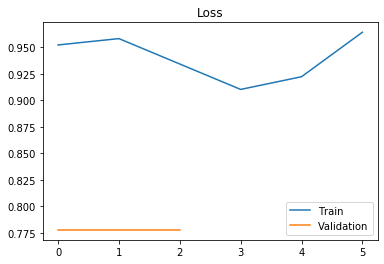

[0.9341317415237427, 0.940119743347168, 0.970059871673584, 0.9281437397003174, 0.946107804775238, 0.946107804775238]


In [30]:
#graphique de la fonction d'évaluation
plt.plot(loss_curve_train, label="Train") #évolution loss jeu d'entraînement
plt.plot(loss_curve_val, label="Validation")
plt.title("Loss")

plt.legend(loc='lower right')

plt.show()
print(loss_curve)




In [ ]:
print("end")